In [2]:
import os
from PIL import Image
import glob

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import metrics

In [3]:
def load_unlabeled_dataset():
    images = []
    # Labeled data
    for f in glob.iglob("./dataset/train/*/*"):
        images.append(np.asarray(Image.open(f)))
    
    # Unlabeled data
    for f in glob.iglob("./dataset/unlabeled/*"):
        images.append(np.asarray(Image.open(f)))
        
    images = np.array(images)
    return images

In [4]:
# Load unlabeled and labeled train data
unlabeled_data = load_unlabeled_dataset()

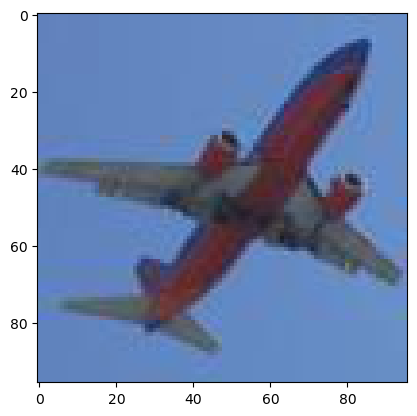

In [5]:
# View an example of an image
plt.imshow(unlabeled_data[0])

In [6]:
def normalize_and_greyscale(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_normalized = cv.normalize(gray, None, 0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
    img_normalized = np.reshape(img_normalized, (96, 96, 1))
    return img_normalized

In [7]:
# Normalize the images
unlabeled_data = [normalize_and_greyscale(img) for img in unlabeled_data]
unlabeled_data = np.asarray(unlabeled_data)

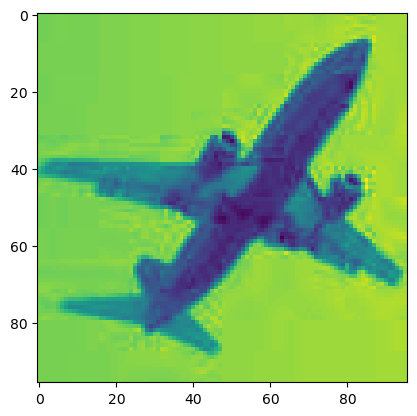

In [8]:
plt.imshow(unlabeled_data[0])

In [9]:
# Split into train and test sets
x_train, x_test, _, _ = train_test_split(unlabeled_data, unlabeled_data, test_size=0.1)

In [35]:
def build_autoencoder():
    model = Sequential()
    model.add(layers.Input(shape=(96, 96, 1)))
    
    # Encoder
    model.add(layers.Conv2D(32, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(48, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(48, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    
    # Decoder
    model.add(layers.Conv2DTranspose(48, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(32, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(48, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(64, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(1, (5, 5), activation="sigmoid", padding="same"))
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[metrics.RootMeanSquaredError()])
    
    return model

In [36]:
# Build autoencoder model
model = build_autoencoder()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 32)        832       
_________________________________________________________________
batch_normalization_24 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 48)        38448     
_________________________________________________________________
batch_normalization_25 (Batc (None, 24, 24, 48)        192       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        76864     
_________________________________________________________________
batch_normalization_26 (Batc (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 48)         

In [16]:
class DataGenerator(Sequence):
    def __init__(self, x_set, batch_size=64):
        self.x = x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.floor(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_x

In [37]:
train_gen = DataGenerator(x_train)
test_gen = DataGenerator(x_test)
model.fit(train_gen, epochs=40, validation_data=test_gen)
model.save("./model_weights/6-6-48")

Epoch 1/40
1546/1546 [==============================] - 115s 74ms/step - loss: 0.5379 - root_mean_squared_error: 0.0934 - val_loss: 0.5365 - val_root_mean_squared_error: 0.0879
Epoch 2/40
1546/1546 [==============================] - 113s 73ms/step - loss: 0.5270 - root_mean_squared_error: 0.0683 - val_loss: 0.5318 - val_root_mean_squared_error: 0.0771
Epoch 3/40
1546/1546 [==============================] - 113s 73ms/step - loss: 0.5246 - root_mean_squared_error: 0.0614 - val_loss: 0.5347 - val_root_mean_squared_error: 0.0768
Epoch 4/40
1546/1546 [==============================] - 114s 74ms/step - loss: 0.5234 - root_mean_squared_error: 0.0577 - val_loss: 0.5320 - val_root_mean_squared_error: 0.0755
Epoch 5/40
1546/1546 [==============================] - 113s 73ms/step - loss: 0.5229 - root_mean_squared_error: 0.0559 - val_loss: 0.5256 - val_root_mean_squared_error: 0.0617
Epoch 6/40
1546/1546 [==============================] - 113s 73ms/step - loss: 0.5224 - root_mean_squared_error: 0.

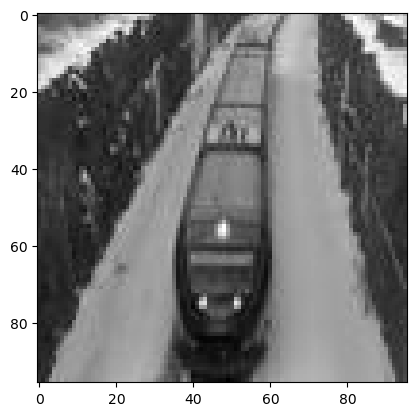

In [46]:
plt.imshow(x_test[101], cmap='gray', vmin=0, vmax=1)

In [38]:
prediction = model.predict(x_test)

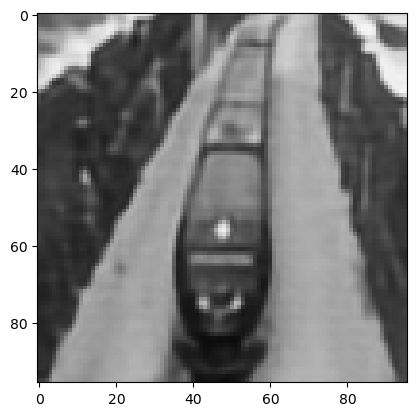

In [47]:
plt.imshow(prediction[101], cmap='gray', vmin=0, vmax=1)